In [30]:
import face_recognition
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# import libaries

from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchinfo import summary
from torchvision import transforms
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, ReLU6, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
from statistics import mean

import datetime
import os

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from mtcnn import MTCNN
import cv2
 


In [31]:
print('Python version:', sys.version)
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    print('GPU Name:', torch.cuda.get_device_name())
    print('GPU Properties:\n', torch.cuda.get_device_properties('cuda'))
    device = "cuda"
    torch.cuda.set_per_process_memory_fraction(0.95, 0)
    torch.cuda.empty_cache()
else:
    print("Cuda is not available, please use cpu instead")
    device = "cpu"
!nvidia-smi

Python version: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070
GPU Properties:
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070', major=7, minor=5, total_memory=8191MB, multi_processor_count=36)
Tue Apr  4 11:40:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8    25W / 175W |   1527Mi

In [32]:
seed = 41
img_size = 112

x


(True, <PIL.Image.Image image mode=RGB size=74x74>)

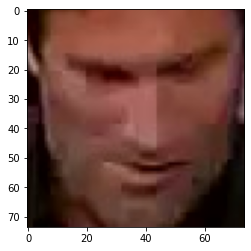

In [40]:
def face_reg(path: str):
    try:
        image = face_recognition.load_image_file(path)
        face_locations = face_recognition.face_locations(image)

        # print("I found {} face(s) in this photograph.".format(len(face_locations)))

        for face_location in face_locations:

            # Print the location of each face in this image
            top, right, bottom, left = face_location
            if top - bottom < 224:
                print('x')

            # You can access the actual face itself like this:
            face_image = image[top:bottom, left:right]
            pil_image = Image.fromarray(face_image)
            plt.imshow(pil_image)
            # print(pil_image)
        return (True, pil_image)
    except:
        print(False, None)



In [33]:
raw_ds_df = pd.read_csv('./csv_files/yt_ds.csv')


In [34]:
raw_ds_df

,Unnamed: 0,sub_identity,identity,path
0,0,0,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\0\0.555.jpg
1,1,0,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\0\0.556.jpg
2,2,0,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\0\0.557.jpg
3,3,0,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\0\0.558.jpg
4,4,0,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\0\0.559.jpg
...,...,...,...,...
390403,390403,1,Zydrunas_Ilgauskas,./frame_images_DB/Zydrunas_Ilgauskas\1\1.1491.jpg
390404,390404,1,Zydrunas_Ilgauskas,./frame_images_DB/Zydrunas_Ilgauskas\1\1.1492.jpg
390405,390405,1,Zydrunas_Ilgauskas,./frame_images_DB/Zydrunas_Ilgauskas\1\1.1493.jpg
390406,390406,1,Zydrunas_Ilgauskas,./frame_images_DB/Zydrunas_Ilgauskas\1\1.1494.jpg


In [ ]:
isFace = list()
for index, row in raw_ds_df.iterrows():
    face_recognition

In [4]:
# ds_df = pd.read_csv('./csv_files/vgg_face.csv')
raw_ds_df = pd.read_csv('./csv_files/yt_ds.csv')
# ds_df = pd.read_csv('./digiface_csv_files/digi_all.csv')
# ds_df = pd.read_csv('./csv_files/lfw_ds.csv')
ds_df = raw_ds_df.groupby(['identity', 'sub_identity'])['path'].apply(list).reset_index()
ds_df

,identity,sub_identity,path
0,AJ_Cook,0,"[./frame_images_DB/AJ_Cook\0\0.123.jpg, ./fram..."
1,AJ_Cook,2,"[./frame_images_DB/AJ_Cook\2\2.131.jpg, ./fram..."
2,Aaron_Eckhart,0,"[./frame_images_DB/Aaron_Eckhart\0\0.555.jpg, ..."
3,Aaron_Eckhart,1,"[./frame_images_DB/Aaron_Eckhart\1\1.183.jpg, ..."
4,Aaron_Eckhart,2,"[./frame_images_DB/Aaron_Eckhart\2\2.1718.jpg,..."
...,...,...,...
3420,Zoran_Djindjic,2,[./frame_images_DB/Zoran_Djindjic\2\2.1973.jpg...
3421,Zulfiqar_Ahmed,1,[./frame_images_DB/Zulfiqar_Ahmed\1\1.1977.jpg...
3422,Zulfiqar_Ahmed,2,[./frame_images_DB/Zulfiqar_Ahmed\2\2.1051.jpg...
3423,Zulfiqar_Ahmed,4,"[./frame_images_DB/Zulfiqar_Ahmed\4\4.155.jpg,..."


In [5]:
name_more = list()
# more than 2 videos 
for name in list(ds_df['identity'].unique()):
    if ds_df[ds_df['identity'] == name].shape[0] >= 2: 
        name_more.append(name)

In [6]:
ds_df[ds_df['identity'].isin(name_more)]

anc_df = pd.DataFrame()
# append all identity 
for identity in name_more: 
    temp_anc = ds_df[ds_df['identity'] == identity].reset_index().T.pop(0)
    anc_df = pd.concat([anc_df, pd.DataFrame(temp_anc).T], axis = 0)

In [7]:
anc_df= anc_df.set_index('index')

In [8]:
anc_df

,identity,sub_identity,path
index,,,
0,AJ_Cook,0,"[./frame_images_DB/AJ_Cook\0\0.123.jpg, ./fram..."
2,Aaron_Eckhart,0,"[./frame_images_DB/Aaron_Eckhart\0\0.555.jpg, ..."
6,Aaron_Sorkin,0,"[./frame_images_DB/Aaron_Sorkin\0\0.100.jpg, ...."
8,Aaron_Tippin,0,"[./frame_images_DB/Aaron_Tippin\0\0.406.jpg, ...."
10,Abba_Eban,0,"[./frame_images_DB/Abba_Eban\0\0.100.jpg, ./fr..."
...,...,...,...
3410,Zhang_Ziyi,1,"[./frame_images_DB/Zhang_Ziyi\1\1.1000.jpg, ./..."
3413,Zhong_Nanshan,0,"[./frame_images_DB/Zhong_Nanshan\0\0.1000.jpg,..."
3416,Zhu_Rongji,0,"[./frame_images_DB/Zhu_Rongji\0\0.561.jpg, ./f..."


In [9]:
# remove less than 2 identity
test_df = ds_df[ds_df['identity'].isin(list(anc_df['identity']))]
test_df

,identity,sub_identity,path
0,AJ_Cook,0,"[./frame_images_DB/AJ_Cook\0\0.123.jpg, ./fram..."
1,AJ_Cook,2,"[./frame_images_DB/AJ_Cook\2\2.131.jpg, ./fram..."
2,Aaron_Eckhart,0,"[./frame_images_DB/Aaron_Eckhart\0\0.555.jpg, ..."
3,Aaron_Eckhart,1,"[./frame_images_DB/Aaron_Eckhart\1\1.183.jpg, ..."
4,Aaron_Eckhart,2,"[./frame_images_DB/Aaron_Eckhart\2\2.1718.jpg,..."
...,...,...,...
3419,Zoran_Djindjic,1,"[./frame_images_DB/Zoran_Djindjic\1\1.104.jpg,..."
3420,Zoran_Djindjic,2,[./frame_images_DB/Zoran_Djindjic\2\2.1973.jpg...
3421,Zulfiqar_Ahmed,1,[./frame_images_DB/Zulfiqar_Ahmed\1\1.1977.jpg...
3422,Zulfiqar_Ahmed,2,[./frame_images_DB/Zulfiqar_Ahmed\2\2.1051.jpg...


In [10]:
# remove the anchor identity and sub_identity
test_df = pd.concat([test_df[['identity','sub_identity']],anc_df[['identity','sub_identity']]]).drop_duplicates(keep=False)
test_df

,identity,sub_identity
1,AJ_Cook,2
3,Aaron_Eckhart,1
4,Aaron_Eckhart,2
7,Aaron_Sorkin,3
9,Aaron_Tippin,1
...,...,...
3417,Zhu_Rongji,1
3419,Zoran_Djindjic,1
3420,Zoran_Djindjic,2
3422,Zulfiqar_Ahmed,2


In [11]:
# get ungroup identity
temp_ds_df = raw_ds_df.copy()
test_df = temp_ds_df.merge(test_df, on = ['identity','sub_identity'])
display(test_df)
# test_df

,Unnamed: 0,sub_identity,identity,path
0,85,1,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\1\1.183.jpg
1,86,1,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\1\1.184.jpg
2,87,1,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\1\1.185.jpg
3,88,1,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\1\1.186.jpg
4,89,1,Aaron_Eckhart,./frame_images_DB/Aaron_Eckhart\1\1.187.jpg
...,...,...,...,...
206484,390203,4,Zulfiqar_Ahmed,./frame_images_DB/Zulfiqar_Ahmed\4\4.263.jpg
206485,390204,4,Zulfiqar_Ahmed,./frame_images_DB/Zulfiqar_Ahmed\4\4.264.jpg
206486,390205,4,Zulfiqar_Ahmed,./frame_images_DB/Zulfiqar_Ahmed\4\4.265.jpg
206487,390206,4,Zulfiqar_Ahmed,./frame_images_DB/Zulfiqar_Ahmed\4\4.266.jpg


In [12]:
test_df = test_df.groupby(['identity'])['path'].apply(list).reset_index()
test_df

,identity,path
0,AJ_Cook,"[./frame_images_DB/AJ_Cook\2\2.131.jpg, ./fram..."
1,Aaron_Eckhart,"[./frame_images_DB/Aaron_Eckhart\1\1.183.jpg, ..."
2,Aaron_Sorkin,"[./frame_images_DB/Aaron_Sorkin\3\3.425.jpg, ...."
3,Aaron_Tippin,"[./frame_images_DB/Aaron_Tippin\1\1.1595.jpg, ..."
4,Abba_Eban,"[./frame_images_DB/Abba_Eban\5\5.10.jpg, ./fra..."
...,...,...
999,Zhang_Ziyi,"[./frame_images_DB/Zhang_Ziyi\2\2.116.jpg, ./f..."
1000,Zhong_Nanshan,"[./frame_images_DB/Zhong_Nanshan\1\1.1675.jpg,..."
1001,Zhu_Rongji,"[./frame_images_DB/Zhu_Rongji\1\1.431.jpg, ./f..."
1002,Zoran_Djindjic,"[./frame_images_DB/Zoran_Djindjic\1\1.104.jpg,..."


In [13]:
check = list()
for inx, each in enumerate(list(test_df['identity'])):
    if list(anc_df['identity'])[inx] == each: 
        check.append(True)
    else: 
        check.append(False)
pd.Series(check).value_counts()

True    1004
dtype: int64

In [15]:
# Define custom dataset
class FaceDataset(Dataset):
    def __init__(self, df,df2, train, num_sample = None, transform = None, num_img_pool = 10, ):
        # set random seed for FaceDataset
        np.random.seed(seed)
        random.seed(seed)
        # create constructors
        self.unique_img_name = None
        self.train = train
        self.data = dict()
        self.images = list()
        self.images2 = list()
        self.identities = list()
        self.identities2 = list()
        # label to indices
        # self.label_to_indices = dict()
        self.labels = list()
        self.labels2 = list()
        self.img_name = list()
        self.img_name2 = list()
        # read csv file
        self.df = df
        self.df2 = df2
        # set the transformation
        self.transform = transform
        # drop last n row from dataframe
        self.df = self.df.head(num_sample)
        #get the length of entire dataset
        self.len_ = len(self.df)
        if num_sample is None or num_sample > self.len_:
            num_sample = self.len_
        # load imgs
        self.load_imgs(self.df, self.df2, num_imgs = num_img_pool, max = num_sample)

    def __len__(self):
        return self.len_

    def __getitem__(self, idx):
        if self.train:
            anchor_img = self.images[idx]
            anchor_label = self.labels[idx]
            pos_idx = np.random.choice(np.arange(len(self.images))[self.labels == anchor_label])
            neg_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])

            pos_img = self.images[pos_idx]
            neg_img = self.images[neg_idx]

            pos_label = self.labels[pos_idx]
            neg_label = self.labels[neg_idx]

            if self.transform is None:
                img_to_tensor = transforms.ToTensor()
                anchor_img = img_to_tensor(anchor_img)
                pos_img = img_to_tensor(pos_img)
                neg_img = img_to_tensor(neg_img)
            else:
                anchor_img = self.transform(anchor_img)
                pos_img = self.transform(pos_img)
                neg_img = self.transform(neg_img)
            return anchor_img, pos_img, neg_img

        else:
            label = False
            anchor_img = self.images[idx]
            anchor_label = self.labels[idx]
            if idx % 2 == 0:
                test_idx = np.random.choice(np.arange(len(self.images))[self.labels == anchor_label])
                label = True

            else:
                test_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])

            neg_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])
            test_img = self.images2[test_idx]
            neg_img = self.images2[neg_idx]

            if self.transform is None:
                img_to_tensor = transforms.ToTensor()
                anchor_img = img_to_tensor(anchor_img)
                test_img = img_to_tensor(test_img)
                neg_img = img_to_tensor(neg_img)

            else:
                anchor_img = self.transform(anchor_img)
                test_img = self.transform(test_img)
                neg_img = self.transform(neg_img)

            return anchor_img, test_img, neg_img ,label, self.identities[idx], self.img_name[idx], self.identities[test_idx], self.img_name[test_idx]
    
    def face_regs(self, path: str):
        try: 
            image = face_recognition.load_image_file(path)
            face_locations = face_recognition.face_locations(image)

            # print("I found {} face(s) in this photograph.".format(len(face_locations)))

            for face_location in face_locations:

                # Print the location of each face in this image
                top, right, bottom, left = face_location
            #     print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

                # You can access the actual face itself like this:
                face_image = image[top:bottom, left:right]
                pil_image = Image.fromarray(face_image).convert('RGB')
    #             plt.imshow(pil_image)
#                 print(pil_image)
            return (True, pil_image)
        except: 
            return (False, None) 

    # load imgs from pandas to memory and define the maximum number of images
    def load_imgs(self, df, df2, num_imgs, max):
        # iterate thought each row
        count_row = 0 
        for i, row in tqdm(df.iterrows(), total = max):
            # get identity of each row
            row_identity = row['identity']
            row_identity2 = df2.iloc[count_row]
            
            # append each identity to numberical value
            # self.label_to_indices[int(row_identity)] = i
            count_img = 0
            # loop imgs in each identity
            for index, img_name in enumerate(row['path']):
                if count_img > num_imgs:
                    break
                # concatenate the directoru and image name
                path_to_image = img_name
                path_to_image2 = np.random.choice(row_identity2['path'])
                (isImg, img) = self.face_regs(path_to_image)
                (isImg2, img2) = self.face_regs(path_to_image2)
                if not (isImg & isImg2):
                    continue
                # open image and convert to RGB
#                 img = Image.open(path_to_image).convert('RGB')
                self.labels.append(i)
                self.images.append(img)
                self.img_name.append(path_to_image)
                self.identities.append(str(row_identity))
                
                self.labels2.append(i)
                self.images2.append(img2)
                self.img_name2.append(path_to_image2)
                self.identities2.append(str(row_identity2))
                
                count_img += 1  # print('Added img '+ str(row_identity))
            count_row +=1 
                
        self.labels = np.array(self.labels)
    def return_val(self):
        return self.labels

In [16]:
face_reg("./frame_images_DB\\Aaron_Tippin\\1\\1.1211.jpg")

False None


In [18]:
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],
                        std = [0.5, 0.5, 0.5])
    ])

# define batch size for testing
test_batch_size = 64
# create dataloader for validation set
val_triplet_dataset = FaceDataset(df = anc_df,df2 = test_df, train = False, num_sample = 100000, transform = test_transform)
val_triplet_dataloader = DataLoader(val_triplet_dataset, batch_size = test_batch_size, shuffle = True,
                                     pin_memory = True)

'./weights/mobile_network_120_updated20230329 020936.pth'

In [19]:
class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output


class h_sigmoid(Module):
    def __init__(self, inplace = True):
        super(h_sigmoid, self).__init__()
        self.relu = ReLU6(inplace = inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(Module):
    def __init__(self, inplace = True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace = inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(Module):
    def __init__(self, channel, reduction = 4):
        super(SELayer, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc = Sequential(Linear(channel, channel // reduction), ReLU(inplace = True),
                             Linear(channel // reduction, channel), h_sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class PermutationBlock(Module):
    def __init__(self, groups):
        super(PermutationBlock, self).__init__()
        self.groups = groups

    def forward(self, input):
        n, c, h, w = input.size()
        G = self.groups
        output = input.view(n, G, c // G, h, w).permute(0, 2, 1, 3, 4).contiguous().view(n, c, h, w)
        return output


class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel = (1, 1), stride = (1, 1), padding = (0, 0), groups = 1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels = out_c, kernel_size = kernel, groups = groups, stride = stride,
                           padding = padding, bias = False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x


class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel = (1, 1), stride = (1, 1), padding = (0, 0), groups = 1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels = out_c, kernel_size = kernel, groups = groups, stride = stride,
                           padding = padding, bias = False)
        self.bn = BatchNorm2d(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class Depth_Wise(Module):
    def __init__(self, in_c, out_c, residual = False, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c = groups, kernel = (1, 1), padding = (0, 0), stride = (1, 1))
        self.conv_dw = Conv_block(groups, groups, groups = groups, kernel = kernel, padding = padding, stride = stride)
        self.project = Linear_block(groups, out_c, kernel = (1, 1), padding = (0, 0), stride = (1, 1))
        self.residual = residual

    def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output


class Residual(Module):
    def __init__(self, c, num_block, groups, kernel = (3, 3), stride = (1, 1), padding = (1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(
                Depth_Wise(c, c, residual = True, kernel = kernel, padding = padding, stride = stride, groups = groups))
        self.model = Sequential(*modules)

    def forward(self, x):
        return self.model(x)


class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start = start_value, stop = stop_value, num = nr_steps)

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1


class DropBlock2D(nn.Module):

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input = mask[:, None, :, :], kernel_size = (
            self.block_size, self.block_size), stride = (1, 1), padding = self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

class MobileFaceNet(Module):
    def __init__(self, embedding_size = 512):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel = (3, 3), stride = (2, 2), padding = (1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel = (3, 3), stride = (1, 1), padding = (1, 1), groups = 64)
        self.conv_23 = Depth_Wise(64, 64, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 128)
        self.conv_3 = Residual(64, num_block = 4, groups = 128, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 256)
        self.conv_4 = Residual(128, num_block = 6, groups = 256, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 512)
        self.conv_5 = Residual(128, num_block = 2, groups = 256, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel = (1, 1), stride = (1, 1), padding = (0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups = 512, kernel = (7, 7), stride = (1, 1), padding = (0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias = False)
        self.bn = BatchNorm1d(embedding_size)
        self.dropblock = DropBlock2D(block_size = 3, drop_prob = 0.25)
        self.dropout = Dropout(0.25)

    def forward_once(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)

        out = self.conv_34(out)
        
        out = self.dropblock(out)

        out = self.conv_4(out)
        
        out = self.dropout(out)

        out = self.conv_45(out)
        
        out = self.dropblock(out)
        
        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.dropblock(out)

        out = self.conv_6_dw(out)

        out = self.dropblock(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)

        return l2_norm(out)

    def forward(self, img):
        anchor = self.forward_once(img)
        return anchor



In [1]:
triplet_model = MobileFaceNet()
print(summary(triplet_model, input_size = [(32, 3, 112, 112)]))

NameError: name 'MobileFaceNet' is not defined

In [21]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average = True):
        # calculate Euclidean's distance
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)

        losses = F.relu(distance_positive - distance_negative + self.margin)

        return torch.mean(losses)
    
# def double_triplet_loss(nn.Module): 
    

In [22]:
def calculate_accuracy(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_positives = np.sum(np.logical_and(predict_issame, actual_issame))
    false_positives = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    true_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    false_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    # For dealing with Divide By Zero exception
    true_positive_rate = 0 if (true_positives + false_negatives == 0) else float(true_positives) / float(
        true_positives + false_negatives)

    false_positive_rate = 0 if (false_positives + true_negatives == 0) else float(false_positives) / float(
        false_positives + true_negatives)

    precision = 0 if (true_positives + false_positives) == 0 else float(true_positives) / float(
        true_positives + false_positives)

    recall = 0 if (true_positives + false_negatives) == 0 else float(true_positives) / float(
        true_positives + false_negatives)

    accuracy = float(true_positives + true_negatives) / dist.size

    #     return true_positive_rate, false_positive_rate, precision, recall, accuracy
    return [true_positive_rate, false_positive_rate, accuracy]

# save the model weight
def save_weight(custom_name: str, model, csv_file: str):
    # check csv file exist 
    if not os.path.exists(csv_file):
        # create new csv_file
        pd.DataFrame(columns = ['date_added', 'path']).to_csv(csv_file)
    # read csv file    
    weight_df = pd.read_csv(csv_file)

    datetime_now = str(datetime.datetime.now())
    save_path = './weights/' + custom_name + datetime_now[:-7].replace('-', '').replace(':', '') + '.pth'

    # create dataframe
    temp_df = pd.DataFrame([[datetime_now, save_path]], columns = ['date_added', 'path'])
    weight_df = pd.concat([weight_df, temp_df], axis = 0, ignore_index = True).drop(['Unnamed: 0'], axis = 1)
    weight_df = weight_df[['date_added', 'path']]
    # save csv 
    weight_df.to_csv(csv_file)
    # save weight 
    save_weight_path = save_path
    torch.save(model.state_dict(), save_weight_path)
    print('Save Success! @' + datetime_now + ' in ' + save_path)
    return save_path


# get the latest weight
def get_latest_weight(csv_path: str) -> str:
    # read csv file
    weight_df = pd.read_csv(csv_path)
    # convert object to datetime type
    weight_df['date_added'] = pd.to_datetime(weight_df['date_added'])
    # sorting date
    weight_df = weight_df.sort_values(by = 'date_added', ascending = False)
    # get latest item
    latest_record = weight_df.head(1)
    print('It was saved at ' + str(latest_record['date_added'].values[0]))
    return weight_df['path'].head(1).values[0]

In [23]:
def train_model(model, train_loader, train_optimizer, train_criterion, weight_path = None):
    train_loss = 0
    train_accuracy = list()
    label_s = list()
    # applied weight
    if weight_path != None:
        model.load_state_dict(weight_path)
    # set to train mode
    model.train()
    # loop though loader
    with torch.set_grad_enabled(True):
        for anchor_img, pos_img, neg_img in tqdm(train_loader):
            # for calculate accuracy
            threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
            is_same = np.full(anchor_img.shape[0], 1)

            # throw img to CUDA
            anchor_img, pos_img, neg_img = anchor_img.to(device), pos_img.to(device), neg_img.to(device)
            # prevent grad vansishing
            train_optimizer.zero_grad()
            # training model
            # anchor_img, pos_img, neg_img = model(anchor_img, pos_img,neg_img)
            anchor_out = model(anchor_img)
            pos_out = model(pos_img)
            neg_out = model(neg_img)
            # calculate distances 
            pos_dists = (anchor_out - pos_out).pow(2).sum(1)
            neg_dists = (anchor_out - neg_out).pow(2).sum(1)
            
            # triplet selections
            if False: 
                first_condition = (neg_dists - pos_dists < model_config['threshold']).cpu().numpy().flatten()
                second_condition = (pos_dists < neg_dists).cpu().numpy().flatten()
                all = (np.logical_and(first_condition, second_condition))
                valid_triplets = np.where(all == 1)
            else: 
                all = (neg_dists - pos_dists < model_config['threshold']).cpu().numpy().flatten()
                valid_triplets = np.where(all == 1)
                
            # calculate loss
            loss = train_criterion(anchor_out, pos_out, neg_out)
            # backpropragation
            loss.backward()
            # compute gradient
            train_optimizer.step()
            # compute train loss
            train_loss += loss.item() * anchor_img.size(0)
    # test_acc, distances, labels =test_model(model, train_loader)

    return train_loss


def test_model(model, test_loader,train_criterion, weight_path: str = None):
    
    test_accuracy = list()
    label_s = list()
    distance_s = list()
    distances_hist = list()
    
    test_imgs_name = list()
    anch_imgs_name = list()
    
    test_identities = list()
    anch_identities = list()
    
    test_loss = 0
    if weight_path is not None:
        model.load_state_dict(torch.load(weight_path))
    # set to train mode
    model.eval()
    # enable grad
    with torch.no_grad():
        # loop though loader
        #anchor_img, test_img, neg_img ,label, self.identities[idx], self.img_name[idx], self.identities[test_idx], self.img_name[test_idx], 

        for index, (anchor_img, test_img, neg_img, label, anch_iden, anch_name, test_iden, test_name) in enumerate(test_loader):
            
            # for calculate accuracy
            threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
            is_same = np.full(anchor_img.shape[0], 1)
            # throw img to CUDA
            anchor_img, test_img, neg_img = anchor_img.to(device), test_img.to(device), neg_img.to(device)
            # compute distance from model
            anchor_out = model(anchor_img)
            test_out = model(test_img)
            neg_out = model(neg_img)
            # calculate loss
            loss = train_criterion(anchor_out,test_out,neg_out)
            # calculate distance between anchor and test images
            distance_val = (anchor_out - test_out).pow(2).sum(1)
            # append label coordinate with each testing pair
            label_s.append(label.cpu().data.numpy())
            distance_s.append(distance_val.cpu().data.numpy())
            test_loss += loss.item() * anchor_img.size(0)
            
            test_imgs_name.append(test_name)
            anch_imgs_name.append(anch_name)
            test_identities.append(test_iden)
            anch_identities.append(anch_iden)
            
        labels_hist = [sub_label for each_label in label_s for sub_label in each_label]
        distance_hist = [sub_distance for each_distance in distance_s for sub_distance in each_distance]
        
        test_imgs_name = [sub for each in test_imgs_name for sub in each]
        anch_imgs_name = [sub for each in anch_imgs_name for sub in each]
        test_identities = [sub for each in test_identities for sub in each]
        anch_identities = [sub for each in anch_identities for sub in each]
        
        test_accuracy.append(calculate_accuracy(np.full(np.size(distance_hist),
                                                        model_config['margin']), np.array(distance_hist), labels_hist)[
                                 2])
    return mean(test_accuracy), distance_hist, labels_hist, test_loss, anch_imgs_name, test_imgs_name, test_identities, anch_identities


In [24]:
model_config = {
    'margin': 0.9,
    'lr': 1e-3,
    'patience': 5,
    'factor': 0.1,
    'min_lr': 1e-10,
    'threshold': 1e-3,
    'weight_decay': 1e-3
    }
criterion = TripletLoss(margin = model_config['margin'])
optimizer = optim.Adam(triplet_model.parameters(), lr = model_config['lr'], weight_decay = model_config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = model_config['patience'],
                                                 factor = model_config['factor'], min_lr = model_config['min_lr'],
                                                 threshold = model_config['threshold'], verbose = True)

In [29]:
# get the latest weight
latest_weight_path = get_latest_weight('./csv_files/weight_records.csv')

acc, distances, labels,loss, anch_imgs_name, test_imgs_name, test_identities, anch_identities = test_model(MobileFaceNet().to(device), val_triplet_dataloader, criterion, './weights/mobile_network_120_updated20230323 035808.pth')
print(f'Accuracy: {acc}')
predict_issame = np.less(distances, (np.full(np.size(np.array(distances)), 0.98)))

It was saved at 2023-03-31T05:43:36.786046000
Accuracy: 0.5139442231075697
